In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

from pandas.io.json import json_normalize

import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [8]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')
exchange

exchange_id exchange_name
0             0       Unknown
1             1         Fyber
2             2        Smaato
3             3         MoPub
4             4        Nexage
5             7       Rubicon
6             8        Google
7             9        Axonix
8            10      PubMatic
9            11        MobFox
10           14         Opera
11           18     PubNative
12           21      Appodeal
13           22         Tappx
14           24      AdColony
15           29     SmartyAds
16           30    Chartboost
17           33   NexageVideo
18           36        Vungle
19           37         Unity
20           38         Unity
21           39         Unity
22           41      AppLovin
23           44        InMobi
24           45          SoMo
25           46  MobilityWare
26           47     GothamAds
27           48      Vertical
28           49          Kiip
29           50        MailRu
30           52          Epom
31           53    TripleLift
32           54    IronSource
33           55      StartApp
34           56       Algorix
35           57     RhythmOne
36           58       Etermax
37           59       Samsung
38           60     ByteDance
39           99          Test

In [7]:
start_dt = '2021-06-08'
change_dt = '2021-06-15'
end_dt = '2021-06-17'

In [23]:
df = bigquery_client.query(f"""
select
    date
    , case when date >= date('{change_dt}') then 2 else 1 end as date_range
    , p.bundle as hosting_bnd
    , p.name as hosting_bnd_name
    , c.name as campaign_name
    , r.ssb_campaign_uuid
    , r.ad_type
    , r.ad_size
    , r.imp_type
    , r.country
    , r.exchange_id
    , case 
        when ctr_model = 'production' or cr_model = 'production' then 'AP' 
        when ctr_model = 'exploration' or cr_model = 'exploration' then 'media scan'
        else 'ML'
    end as bidder
    , count(case when event_type = 'clear' then 1 else NULL end)*16 as impressions
    , count(case when event_type = 'click' then 1 else NULL end)*16 as clicks
    , count(case when event_type = 'install' then 1 else NULL end)*16 as installs
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)*16/1000 as bid
from stats.rows1 r
join metadata.apps p
    on r.hosting_app_id = p.app_id
join metadata.dt_campaigns c
    on r.ssb_campaign_uuid = c.uuid
    and c.name like '%Twitter%'
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and left(r.id,1) = '0'
group by 1,2,3,4,5,6,7,8,9,10,11,12
""").to_dataframe()
df = pd.merge(df, exchange, left_on = 'exchange_id', right_on = 'exchange_id', how = 'left')
df = pd.merge(df, imp_type, left_on = 'imp_type', right_on = 'imp_type_id', how = 'left')
df['date'] = df['date'].astype('datetime64')
df['spend'] = df['spend'].astype('float')
df['cost'] = df['cost'].astype('float')
df

date  date_range                            hosting_bnd  \
0      2021-06-17           2                      com.pioint.fnc.wd   
1      2021-06-11           1       com.easybrain.block.puzzle.games   
2      2021-06-10           1                 com.moonfrog.ludo.club   
3      2021-06-11           1  scratch.lucky.money.free.real.big.win   
4      2021-06-10           1                          com.taggedapp   
...           ...         ...                                    ...   
554056 2021-06-10           1                    com.jogatina.tranca   
554057 2021-06-09           1                com.lbrc.PeriodCalendar   
554058 2021-06-10           1                      com.photoroulette   
554059 2021-06-14           1                     com.picsart.studio   
554060 2021-06-11           1                             wp.wattpad   

                                        hosting_bnd_name  \
0                                      Point Blur Studio   
1                        Blockudoku® - Block Puzzle Game   
2                              Ludo Club - Fun Dice Game   
3                Lucky Money - Feel Great & Make it Rain   
4                           Tagged - Meet, Chat & Dating   
...                                                  ...   
554056                                   Tranca Jogatina   
554057                      My Calendar - Period Tracker   
554058                                    Photo Roulette   
554059  PicsArt Photo Editor: Pic, Video & Collage Maker   
554060                    Wattpad - Read & Write Stories   

                           campaign_name                 ssb_campaign_uuid  \
0            Twitter - Twitter - BR - GP  949d2cb0616d95548bf7a4010a611373   
1           Android-Twitter-Twitter-PT-4  fc2ba0e560c59f4ee98f9e8b6f7d89d4   
2           Android-Twitter-Twitter-PT-4  fc2ba0e560c59f4ee98f9e8b6f7d89d4   
3            Twitter - Twitter - BR - GP  949d2cb0616d95548bf7a4010a611373   
4           Android-Twitter-Twitter-SA-4  7da94c33fae6e9612d3069336c59e09c   
...                                  ...                               ...   
554056  Twitter - Twitter - BR - True GP  b7c89cdb901658c9b5cde8b89203d0f0   
554057  Twitter - Twitter - BR - True GP  b7c89cdb901658c9b5cde8b89203d0f0   
554058  Twitter - Twitter - BR - True GP  b7c89cdb901658c9b5cde8b89203d0f0   
554059  Twitter - Twitter - BR - True GP  b7c89cdb901658c9b5cde8b89203d0f0   
554060  Twitter - Twitter - BR - True GP  b7c89cdb901658c9b5cde8b89203d0f0   

       ad_type   ad_size  imp_type country  exchange_id bidder  impressions  \
0        inter   320x480         1      BR            1     ML          416   
1       banner    320x50         1      PT            3     AP          144   
2        inter   320x480         1      PT           37     ML          224   
3        inter  768x1024        16      BR           41     ML          528   
4       banner    320x50         1      SA            3     AP          336   
...        ...       ...       ...     ...          ...    ...          ...   
554056  banner    320x50         1      BR            7     ML           32   
554057  banner       0x0         4      BR            3     ML          880   
554058   inter  768x1024         2      BR           41     ML           64   
554059   inter   320x480         1      BR            3     ML          864   
554060  banner    320x50         1      BR           41     ML         8480   

        clicks  installs  spend      cost       bid exchange_name  
0          128         0    0.0  0.300432  0.300264         Fyber  
1            0         0    0.0  0.008640  0.008640         MoPub  
2            0         0    0.0  0.257280  0.257283         Unity  
3           64         0    0.0  0.932800  0.932102      AppLovin  
4            0         0    0.0  0.020160  0.020160         MoPub  
...        ...       ...    ...       ...       ...           ...  
554056       0         0    0.0  0.001392  0.001397       Rubicon

In [24]:
df['campaign_name'] = df['campaign_name'].fillna(0)

exp_1 = [' rt','-rt',' pr','-pr',' retar','-retar','-1','- 1']
exp_2 = [' ua','-ua','-2','- 2']
exp_3 = [' gp','-gp','-3','- 3']
exp_4 = ['true gp','true-gp','true_gp','-4','- 4']
exp_1_uuid = ['33bff90d655b976e9399f1d0b0463d22','eb6dbe92b98fe9a91b00eb06ae37070e','5c2cc36dc709f65250ad09e9926f2020','d8be47c87ebd5047c552f92421103f1a','dad68c13e535c25d96b8a8af78f04033','608ffd6123bdbf7eef34f27889501862','5fef83d15c5b811b424ed58aeb82d0a7']
exp_2_uuid = ['06999d835967801342ac5e0138b30d6b','1f6365ce92548cbaa4f0c8977e77456d','ba0b27afb4dbdaf333f43f8f13b9ee5d','fbc615e1cde9d19c9e8b242169446835','d68c7b0af30354df7c23485a57b8f17e','6e8c92368479165b5464224b5dc43075','3cf6d5969d0fbd8d395b24d0d3cfffae','a2866facee769a34a4a20a3f77bf134a','1a677bdff57ac529612052ffe2c29943','d3b1408721e726a89e34392b8562f61f','b7674540eb94d62830fbc90775d3b95a','46de0fb1f9463e29e66f93ab245d8f0f','a8c01640a10802a1f972029013ad9fc6','38c3a02f8e03b65d410949bcf63a0067','a13d7795071a0b46cf2b0cf31598fa78','2359e9439151f256228cedd5f8780ed4','6c1828f2d2e75b3bda200107fd8c3ec5','729de681656730b0c02ebd707962aec0','dc8a4abf464703b89a87bc19b990deda','8ab98b279f571f61349ab6138d0f51f6','43242a117923679a04b02c58f671f1a8','cfbad4e5cdfcf8e68d0ff1ddb5135586','588e866f5823fe5cc89fce3b0370eff0']
exp_3_uuid = []
exp_4_uuid = ['8f6af55d3b890df1566e59c4bcf13d3c','f1d182a7fabffea0694ae7287aa26c0d']

def classify_campaigns(r):
    if r['ssb_campaign_uuid'] in exp_1_uuid:
        return 1
    elif r['ssb_campaign_uuid'] in exp_2_uuid:
        return 2
    elif r['ssb_campaign_uuid'] in exp_3_uuid:
        return 3
    elif r['ssb_campaign_uuid'] in exp_4_uuid:
        return 4
    elif any(substr in str(r['campaign_name']).lower() for substr in exp_1):
        return 1
    elif any(substr in str(r['campaign_name']).lower() for substr in exp_4):
        return 4
    elif any(substr in str(r['campaign_name']).lower() for substr in exp_3):
        return 3
    elif any(substr in str(r['campaign_name']).lower() for substr in exp_2):
        return 2
    else:
        return -1
    
df['experience_type'] = df.apply(lambda x:classify_campaigns(x), axis = 1)

In [25]:
format_mapping = {'ctr':'{0:.1f}%'
                  ,'ir':'{0:.1f}%'
                  ,'ipm':'{0:.2f}'
                  ,'rpi':'${:,.2f}'
                  ,'cpm':'${:,.2f}'
                  ,'bpm':'${:,.2f}'
                  ,'cost':'${:,.0f}'
                  ,'spend':'${:,.0f}'
                  ,'sov':'{0:.0f}%'
                  ,'imp_sov':'{0:.0f}%'
                  ,'margin':'{0:.0f}%'
                  ,'impressions':'{:,.0f}'
                  ,'clicks':'{:,.0f}'
                  ,'installs':'{:,.0f}'
                 }

def calc_metrics(df, agg_col = np.nan):
    df['ctr'] = df['clicks']/df['impressions']
    df['ir'] = df['installs']/df['clicks']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['rpi'] = df['spend']/df['installs']
    df['cpm'] = 1000*df['cost']/df['impressions']
    df['bpm'] = 1000*df['bid']/df['impressions']
    try:
        grouped_sum = df['spend'].groupby(agg_col).sum()
    except:
        grouped_sum = df['spend'].sum()
    df['sov'] = df['spend']/grouped_sum
    try:
        grouped_imp_sum = df['impressions'].groupby(agg_col).sum()
    except:
        grouped_imp_sum = df['impressions'].sum()
    df['imp_sov'] = df['impressions']/grouped_imp_sum
    df['margin'] = (df['spend']-df['cost'])/df['spend']
    df.sort_values('sov', ascending = False, inplace = True)
    
def color_format(x, format_str = "{:.2f}", sort_order = ['experience_type', 'sov']):
    x[['ctr','ir','imp_sov','sov','margin']] = 100*x[['ctr','ir','imp_sov','sov','margin']]
    x.sort_values(sort_order, ascending = [True]*(len(sort_order)-1) + [False], inplace = True)
    return x.style.format(format_str).background_gradient(cmap=cm, axis = 0).applymap(lambda x:'background-color: white;color: white' if np.isnan(x) else '')

In [26]:
df

date  date_range                            hosting_bnd  \
0      2021-06-17           2                      com.pioint.fnc.wd   
1      2021-06-11           1       com.easybrain.block.puzzle.games   
2      2021-06-10           1                 com.moonfrog.ludo.club   
3      2021-06-11           1  scratch.lucky.money.free.real.big.win   
4      2021-06-10           1                          com.taggedapp   
...           ...         ...                                    ...   
554056 2021-06-10           1                    com.jogatina.tranca   
554057 2021-06-09           1                com.lbrc.PeriodCalendar   
554058 2021-06-10           1                      com.photoroulette   
554059 2021-06-14           1                     com.picsart.studio   
554060 2021-06-11           1                             wp.wattpad   

                                        hosting_bnd_name  \
0                                      Point Blur Studio   
1                        Blockudoku® - Block Puzzle Game   
2                              Ludo Club - Fun Dice Game   
3                Lucky Money - Feel Great & Make it Rain   
4                           Tagged - Meet, Chat & Dating   
...                                                  ...   
554056                                   Tranca Jogatina   
554057                      My Calendar - Period Tracker   
554058                                    Photo Roulette   
554059  PicsArt Photo Editor: Pic, Video & Collage Maker   
554060                    Wattpad - Read & Write Stories   

                           campaign_name                 ssb_campaign_uuid  \
0            Twitter - Twitter - BR - GP  949d2cb0616d95548bf7a4010a611373   
1           Android-Twitter-Twitter-PT-4  fc2ba0e560c59f4ee98f9e8b6f7d89d4   
2           Android-Twitter-Twitter-PT-4  fc2ba0e560c59f4ee98f9e8b6f7d89d4   
3            Twitter - Twitter - BR - GP  949d2cb0616d95548bf7a4010a611373   
4           Android-Twitter-Twitter-SA-4  7da94c33fae6e9612d3069336c59e09c   
...                                  ...                               ...   
554056  Twitter - Twitter - BR - True GP  b7c89cdb901658c9b5cde8b89203d0f0   
554057  Twitter - Twitter - BR - True GP  b7c89cdb901658c9b5cde8b89203d0f0   
554058  Twitter - Twitter - BR - True GP  b7c89cdb901658c9b5cde8b89203d0f0   
554059  Twitter - Twitter - BR - True GP  b7c89cdb901658c9b5cde8b89203d0f0   
554060  Twitter - Twitter - BR - True GP  b7c89cdb901658c9b5cde8b89203d0f0   

       ad_type   ad_size  imp_type country  exchange_id bidder  impressions  \
0        inter   320x480         1      BR            1     ML          416   
1       banner    320x50         1      PT            3     AP          144   
2        inter   320x480         1      PT           37     ML          224   
3        inter  768x1024        16      BR           41     ML          528   
4       banner    320x50         1      SA            3     AP          336   
...        ...       ...       ...     ...          ...    ...          ...   
554056  banner    320x50         1      BR            7     ML           32   
554057  banner       0x0         4      BR            3     ML          880   
554058   inter  768x1024         2      BR           41     ML           64   
554059   inter   320x480         1      BR            3     ML          864   
554060  banner    320x50         1      BR           41     ML         8480   

        clicks  installs  spend      cost       bid exchange_name  \
0          128         0    0.0  0.300432  0.300264         Fyber   
1            0         0    0.0  0.008640  0.008640         MoPub   
2            0         0    0.0  0.257280  0.257283         Unity   
3           64         0    0.0  0.932800  0.932102      AppLovin   
4            0         0    0.0  0.020160  0.020160         MoPub   
...        ...       ...    ...       ...       ...           ...   
554056       0         0    0.0  0.001392  0.001397       

In [71]:
i = ['date_range']
pivot = df[df.campaign_name == 'Android-Twitter-Twitter-ID-4'].pivot_table(values = ['impressions','clicks','installs','spend','cost','bid']
                                                                          ,index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','cpm','bpm','rpi','spend','sov','cost','margin']
color_format(pivot[cols], format_mapping, sort_order = ['date_range','sov'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-25-d08c1dc7f9f0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.sort_values(sort_order, ascending = [True]*(len(sort_order)-1) + [False], inplace = True)


In [128]:
i = ['date_range','exchange_name']
pivot = df[df.campaign_name == 'Android-Twitter-Twitter-ID-4'].pivot_table(values = ['impressions','clicks','installs','spend','cost','bid']
                                                                          ,index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','cpm','bpm','rpi','spend','sov','cost','margin']
color_format(pivot[cols], format_mapping, sort_order = ['exchange_name','date_range','sov'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-25-d08c1dc7f9f0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.sort_values(sort_order, ascending = [True]*(len(sort_order)-1) + [False], inplace = True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax +

IPM almost tripled on Fyber. Charboost also increased some.

In [130]:
i = ['impression type','ad_type','date_range']
pivot = df[df.campaign_name == 'Android-Twitter-Twitter-ID-4'].pivot_table(values = ['impressions','clicks','installs','spend','cost','bid']
                                                                          ,index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','cpm','bpm','rpi','spend','sov','cost','margin']
color_format(pivot[cols], format_mapping, sort_order = ['impression type','ad_type','date_range','sov'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-25-d08c1dc7f9f0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.sort_values(sort_order, ascending = [True]*(len(sort_order)-1) + [False], inplace = True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax +

* display Interstitial CTRs went up 3%
* Video IRs increased .3%, bringing the IPMs to triple

In [129]:
i = ['exchange_name','impression type','ad_type','date_range']
filters = (df.campaign_name == 'Android-Twitter-Twitter-ID-4') & ((df['impression type'] == 'display') | (df['impression type'].str.contains('video'))) & (df.exchange_name.isin(['Mopub','Fyber','Unity','AppLovin','Chartboost']))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','cost','bid']
                                                                          ,index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','cpm','bpm','rpi','spend','sov','cost','margin']
color_format(pivot[cols], format_mapping, sort_order = ['exchange_name','impression type','ad_type','date_range','sov'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-25-d08c1dc7f9f0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.sort_values(sort_order, ascending = [True]*(len(sort_order)-1) + [False], inplace = True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax +

* Display's increase was all on Fyber
* Video's increase is spread pretty evenly, with the slight leader being AppLovin.

In [133]:
i = ['exchange_name','hosting_bnd','date_range']
filters = (df.campaign_name == 'Android-Twitter-Twitter-ID-4') & (df['impression type'] == 'display') & (df.ad_type == 'inter') & (df.exchange_name.isin(['Fyber','Unity']))
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','cost','bid']
                                                                          ,index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','cpm','bpm','rpi','spend','sov','cost','margin']
color_format(pivot.loc[pivot.installs > 100,cols], format_mapping, sort_order = ['hosting_bnd','date_range','sov'])

In [70]:
i = ['hosting_bnd','date']
filters = (df.campaign_name == 'Android-Twitter-Twitter-ID-4') & (df.hosting_bnd == 'com.picsart.studio') & (df.ad_size == '320x480') & (df['impression type'] == 'display')
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','cost','bid']
                                                                          ,index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','cpm','bpm','rpi','spend','sov','cost','margin']

pivot[['ctr','ir','imp_sov','sov','margin']] = 100*pivot[['ctr','ir','imp_sov','sov','margin']]
pivot.sort_index(0, inplace = True)
pivot.loc[:,cols].style.format(format_mapping).background_gradient(cmap=cm, axis = 0).applymap(lambda x:'background-color: white;color: white' if np.isnan(x) else '')

In [73]:
i = ['hosting_bnd','campaign_name','date_range']
filters = (df.hosting_bnd == 'com.picsart.studio') & (df['impression type'] == 'display') 
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','cost','bid']
                                                                          ,index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','cpm','bpm','rpi','spend','sov','cost','margin']
color_format(pivot.loc[pivot.installs > 10,cols], format_mapping, sort_order = ['hosting_bnd','date_range','sov'])

In [124]:
df_picsart = bigquery_client.query(f"""
select
    date
    , case when date >= date('{change_dt}') then 2 else 1 end as date_range
    , c.name as campaign_name
    , sp.name as sponsored_bnd_name
    , p.bundle
    , count(case when event_type = 'clear' then 1 else NULL end)*16 as impressions
    , count(case when event_type = 'click' then 1 else NULL end)*16 as clicks
    , count(case when event_type = 'install' then 1 else NULL end)*16 as installs
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)*16/1000 as bid
from stats.rows1 r
join metadata.apps p
    on r.hosting_app_id = p.app_id
    and p.bundle = 'com.picsart.studio'
join metadata.dt_campaigns c
    on r.ssb_campaign_uuid = c.uuid
join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and left(r.id,1) = '0'
    and r.ad_size = '320x480'
    and r.exchange_id = 1
group by 1,2,3,4,5
""").to_dataframe()

In [127]:
df_picsart.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = 'sponsored_bnd_name', aggfunc = np.sum).sort_values('spend', ascending = False)

clicks         cost  \
sponsored_bnd_name                                                      
Twitter                                           374432  4954.377093   
Kwai - Watch cool and funny videos                     0     0.050227   
NewsBreak: Local Breaking Stories & US Headlines       0     0.125409   
Ripio Bitcoin Wallet: the new digital economy          0     0.132079   
TikTok                                                16     0.124798   

                                                  impressions  installs  \
sponsored_bnd_name                                                        
Twitter                                               4349248      3104   
Kwai - Watch cool and funny videos                         64         0   
NewsBreak: Local Breaking Stories & US Headlines           16         0   
Ripio Bitcoin Wallet: the new digital economy             288         0   
TikTok                                                    176         0   

                                                    spend  
sponsored_bnd_name                                         
Twitter                                           13704.0  
Kwai - Watch cool and funny videos                    0.0  
NewsBreak: Local Breaking Stories & US Headlines      0.0  
Ripio Bitcoin Wallet: the new digital economy         0.0  
TikTok                                                0.0

In [138]:
i = ['hosting_bnd','ad_size','date']
filters = (df.campaign_name == 'Android-Twitter-Twitter-ID-4') & (df.hosting_bnd == 'jp.garud.ssimulator') & (df['impression type'] == 'display') & (df.ad_size == '480x320')
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','cost','bid']
                                                                          ,index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','cpm','bpm','rpi','spend','sov','cost','margin']

pivot[['ctr','ir','imp_sov','sov','margin']] = 100*pivot[['ctr','ir','imp_sov','sov','margin']]
pivot.sort_index(0, inplace = True)
pivot.loc[:,cols].style.format(format_mapping).background_gradient(cmap=cm, axis = 0).applymap(lambda x:'background-color: white;color: white' if np.isnan(x) else '')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


## Looking at Unity inter increase

In [119]:
i = ['exchange_name','hosting_bnd','date_range']
filters = (df.campaign_name == 'Android-Twitter-Twitter-ID-4') & (df['impression type'] == 'display') & (df.exchange_name == 'Unity') 
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','cost','bid']
                                                                          ,index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','cpm','bpm','rpi','spend','sov','cost','margin']
color_format(pivot.loc[(pivot.clicks > 1000) | (pivot.installs > 32),cols], format_mapping, sort_order = ['hosting_bnd','date_range','sov'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


In [142]:
df_ctit = bigquery_client.query(f"""
select
    c.date
    , case when c.date >= date('{change_dt}') then 2 else 1 end as date_range
    , c.etimestamp as click_ts
    , i.etimestamp as install_ts
from 
(
    select
        date
        , r.id
        , r.etimestamp
    from stats.rows1 r
    join metadata.apps p
        on r.hosting_app_id = p.app_id
        and p.bundle = 'com.picsart.studio'
    join metadata.dt_campaigns c
        on r.ssb_campaign_uuid = c.uuid
        and c.name = 'Android-Twitter-Twitter-ID-4'
    where 
        date >= '{start_dt}'
        and date <= '{end_dt}'
        and event_type = 'click'
) c
join 
(
    select
        r.id
        , r.etimestamp
    from stats.rows1 r
    join metadata.apps p
        on r.hosting_app_id = p.app_id
        and p.bundle = 'com.picsart.studio'
    join metadata.dt_campaigns c
        on r.ssb_campaign_uuid = c.uuid
        and c.name = 'Android-Twitter-Twitter-ID-4'
    where 
        date >= '{start_dt}'
        and date <= '{end_dt}'
        and event_type = 'install'
) i
    on c.id = i.id
group by 1,2,3,4
""").to_dataframe()

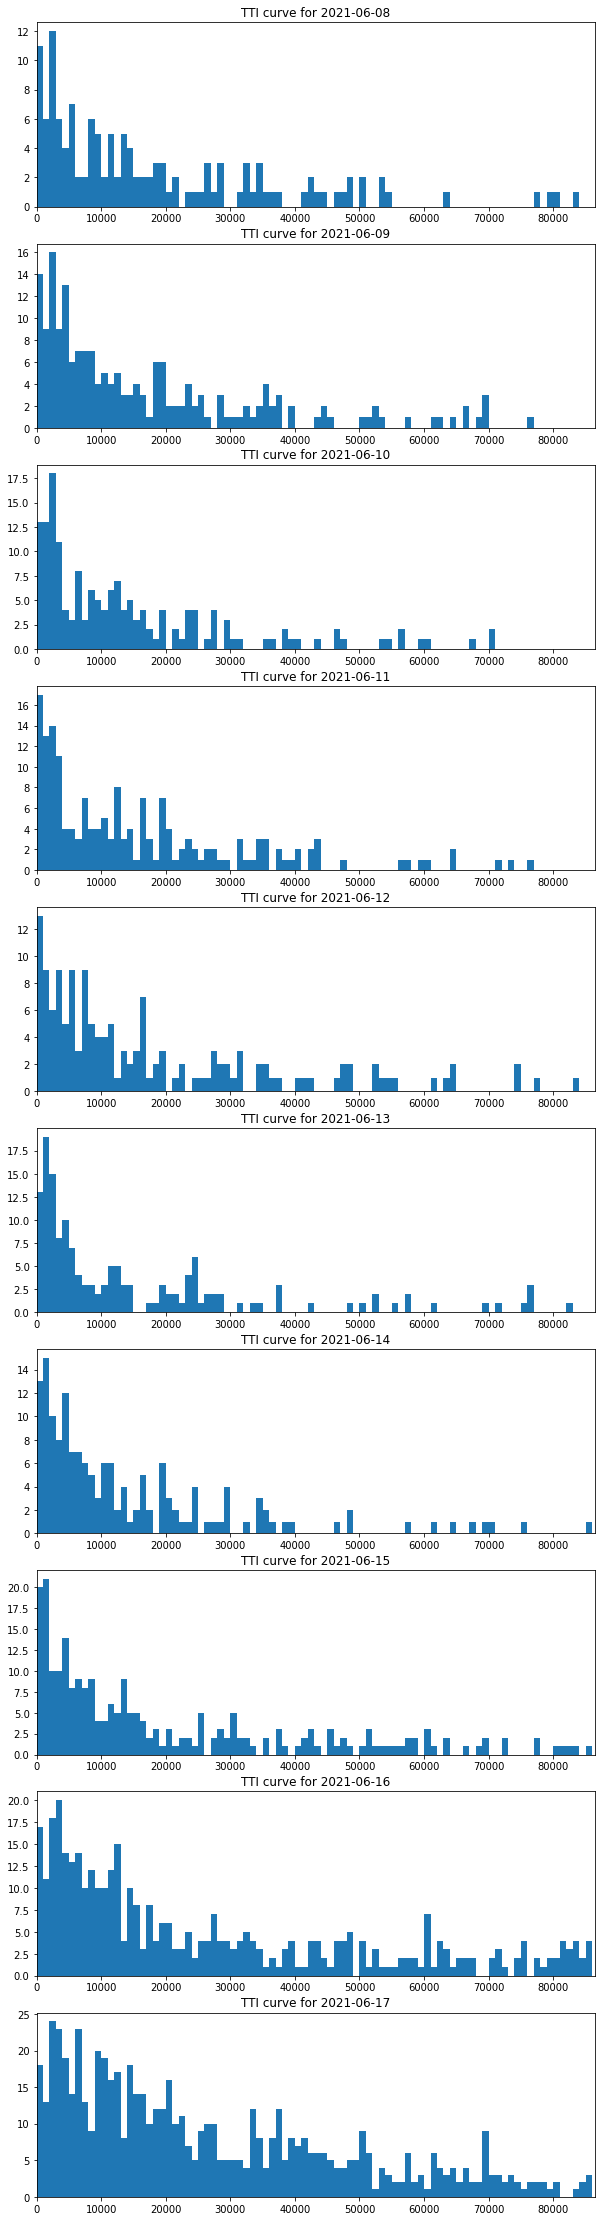

In [147]:
df_ctit['tti'] = (df_ctit.install_ts - df_ctit.click_ts).astype('timedelta64[s]')
fig, ax = plt.subplots(10,1, figsize = (10,40))
i = 0
for d in pd.date_range(start = start_dt, end = end_dt):
    filters = (df_ctit.date == d) & (df_ctit.tti < 7*86400)
    ax[i].hist(df_ctit.loc[filters, 'tti'], bins = [n for n in list(range(0,86400,1000))])
    ax[i].set_xlim(0,86400)
    ax[i].set_title('TTI curve for {}'.format(d.strftime('%Y-%m-%d')))
    i += 1